<a href="https://colab.research.google.com/github/TAUforPython/BioMedAI/blob/main/autoencoder_deep_learning_v1_EB.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Загрузка библиотек и подготовка файла к обработке

In [ ]:
!pip install mne pywavelets numpy matplotlib pyedflib scipy tensorflow
import mne
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import butter, filtfilt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, Dense, Lambda
from tensorflow.keras.optimizers import Adam
import tensorflow.keras.backend as K
import pyedflib
import pywt
from scipy import signal
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import tensorflow as tf

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 13.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.7/2.7 MB 12.2 MB/s eta 0:00:00


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install -U -q PyDrive2
from pydrive2.auth import GoogleAuth
from pydrive2.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# Авторизация и создание клиента PyDrive
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.7/46.7 kB 1.7 MB/s eta 0:00:00


### Обработка данных

In [ ]:
common_path = '/content/drive/MyDrive/edf_process1/'
another_path = '/content/drive/MyDrive/SkolNeuro/'

# Список путей к файлам EDF
file_paths = [common_path+'EEG_7134.edf', common_path+'EEG_7129.edf', common_path+'EEG_2171.edf', common_path+'EEG_1747.edf',
              common_path+'EEG_1732.edf', common_path+'EEG_1728.edf', common_path+'EEG_1714.edf', common_path+'EEG_1697.edf',
              common_path+'EEG_1695.edf', common_path+'EEG_1687.edf', common_path+'EEG_793.edf', common_path+'EEG_792.edf',
              common_path+'EEG_665.edf', common_path+'EEG_595.edf', common_path+'EEG_531.edf', common_path+'EEG_423.edf',
              common_path+'EEG_330.edf', common_path+'EEG_261.edf', common_path+'EEG_239.edf', common_path+'EEG_152.edf',
              common_path+'EEG_109.edf', common_path+'EEG_95.edf', common_path+'EEG_85.edf', common_path+'EEG_80.edf',
              common_path+'EEG_70.edf', common_path+'EEG_68.edf', common_path+'EEG_53.edf', common_path+'EEG_47.edf',
              common_path+'EEG_28.edf', another_path+'EEG_21.edf', another_path+'EEG_68.edf', another_path+'P010.EDF']

def split_data_into_chunks(data, chunk_size=128):

    num_channels, num_samples = data.shape
    train_data = []

    for channel in range(num_channels):
        channel_data = data[channel]
        channel_chunks = [channel_data[i:i + chunk_size] for i in range(0, num_samples, chunk_size)]
        train_data.append(channel_chunks)

    return np.array(train_data)

# Пустой список для обработанных и разделенных данных
processed_and_splitted_data = []

# Обработка каждого файла
for file_path in file_paths:
    raw_data = mne.io.read_raw_edf(file_path, preload=True)  # Загрузка данных

    # Выполнение обработки данных с помощью фильтрации или других преобразований

    # Фильтрация сигнала фильтром Баттерворта
    filtered_raw = raw_data.copy().filter(0.5, 50, method='fir', fir_design='firwin')

    # Прямая и обратная фильтрация
    filtered_signal = filtered_raw.get_data(picks='eeg')
    forward_filtered_signal = mne.filter.filter_data(filtered_signal, sfreq=raw_data.info['sfreq'], l_freq=None, h_freq=None, method='fir',
                                                     fir_window='hamming', fir_design='firwin2')
    backward_filtered_signal = mne.filter.filter_data(forward_filtered_signal, sfreq=raw_data.info['sfreq'], l_freq=None, h_freq=None, method='fir',
                                                     fir_window='hamming', fir_design='firwin2', iir_params=None, picks=None, n_jobs=1)

    # Вейвлет-преобразование Добеши 4 порядка, 6 уровней
    wavelet = pywt.Wavelet('db4')
    coeffs = pywt.wavedec(backward_filtered_signal, wavelet, level=6)

    coeffs[1:] = [pywt.threshold(i, value=0, mode='soft') if i is not None else None for i in coeffs[1:]]
    wavelet_filtered = pywt.waverec(coeffs, wavelet)

    # Проверяем и дополняем данные нулями, если необходимо
    if len(wavelet_filtered) < len(raw_data.get_data()):
        diff_len = len(raw_data.get_data()) - len(wavelet_filtered)
        wavelet_filtered = np.concatenate([wavelet_filtered, np.zeros(diff_len)])

    # Создаем новый объект RawArray
    info = mne.create_info(ch_names=raw_data.info['ch_names'], sfreq=raw_data.info['sfreq'], ch_types='eeg')
    raw_filt = mne.io.RawArray(wavelet_filtered, info)

    # Разделяем данные на кусочки и добавляем в список
    processed_and_splitted_data.append(split_data_into_chunks(raw_filt.get_data()))
    #splitted_data = split_into_chunks(raw_filt.get_data(), chunk_size=128)
    #processed_and_splitted_data.extend(splitted_data)  # Добавление кусочков в список


Extracting EDF parameters from /content/drive/MyDrive/edf_process1/EEG_7134.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 3686527  =      0.000 ... 28800.992 secs...


<ipython-input-39-63d548ab059b>:31: RuntimeWarning: Channel names are not unique, found duplicates for: {'EEG Fp2-G2', 'EEG Fp1-G2'}. Applying running numbers for duplicates.
  raw_data = mne.io.read_raw_edf(file_path, preload=True)  # Загрузка данных
<ipython-input-39-63d548ab059b>:31: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw_data = mne.io.read_raw_edf(file_path, preload=True)  # Загрузка данных
<ipython-input-39-63d548ab059b>:31: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw_data = mne.io.read_raw_edf(file_path, preload=True)  # Загрузка данных


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 845 samples (6.602 s)


FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal allpass filter:
- Windowed frequency-domain design (firwin2) method
- Hamming window
- Filter length: 1 samples (0.008 s)


FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal allpass filter:
- Windowed frequency-domain design (firwin2) method
- Hamming window
- Filter length: 1 samples (0.008 s)

Creating Ra

<ipython-input-39-63d548ab059b>:31: RuntimeWarning: Channel names are not unique, found duplicates for: {'EEG Fp2-G2', 'EEG Fp1-G2'}. Applying running numbers for duplicates.
  raw_data = mne.io.read_raw_edf(file_path, preload=True)  # Загрузка данных
<ipython-input-39-63d548ab059b>:31: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw_data = mne.io.read_raw_edf(file_path, preload=True)  # Загрузка данных
<ipython-input-39-63d548ab059b>:31: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw_data = mne.io.read_raw_edf(file_path, preload=True)  # Загрузка данных


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 845 samples (6.602 s)


FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal allpass filter:
- Windowed frequency-domain design (firwin2) method
- Hamming window
- Filter length: 1 samples (0.008 s)


FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal allpass filter:
- Windowed frequency-domain design (firwin2) method
- Hamming window
- Filter length: 1 samples (0.008 s)

Creating Ra

<ipython-input-39-63d548ab059b>:31: RuntimeWarning: Channel names are not unique, found duplicates for: {'EEG Fp2-G2', 'EEG Fp1-G2'}. Applying running numbers for duplicates.
  raw_data = mne.io.read_raw_edf(file_path, preload=True)  # Загрузка данных
<ipython-input-39-63d548ab059b>:31: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw_data = mne.io.read_raw_edf(file_path, preload=True)  # Загрузка данных
<ipython-input-39-63d548ab059b>:31: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw_data = mne.io.read_raw_edf(file_path, preload=True)  # Загрузка данных


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 845 samples (6.602 s)


FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal allpass filter:
- Windowed frequency-domain design (firwin2) method
- Hamming window
- Filter length: 1 samples (0.008 s)


FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal allpass filter:
- Windowed frequency-domain design (firwin2) method
- Hamming window
- Filter length: 1 samples (0.008 s)

Creating Ra

<ipython-input-39-63d548ab059b>:31: RuntimeWarning: Channel names are not unique, found duplicates for: {'EEG Fp2-G2', 'EEG Fp1-G2'}. Applying running numbers for duplicates.
  raw_data = mne.io.read_raw_edf(file_path, preload=True)  # Загрузка данных
<ipython-input-39-63d548ab059b>:31: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw_data = mne.io.read_raw_edf(file_path, preload=True)  # Загрузка данных
<ipython-input-39-63d548ab059b>:31: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw_data = mne.io.read_raw_edf(file_path, preload=True)  # Загрузка данных


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 845 samples (6.602 s)


FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal allpass filter:
- Windowed frequency-domain design (firwin2) method
- Hamming window
- Filter length: 1 samples (0.008 s)


FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal allpass filter:
- Windowed frequency-domain design (firwin2) method
- Hamming window
- Filter length: 1 samples (0.008 s)

Creating Ra

<ipython-input-39-63d548ab059b>:31: RuntimeWarning: Channel names are not unique, found duplicates for: {'EEG Fp2-G2', 'EEG Fp1-G2'}. Applying running numbers for duplicates.
  raw_data = mne.io.read_raw_edf(file_path, preload=True)  # Загрузка данных
<ipython-input-39-63d548ab059b>:31: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw_data = mne.io.read_raw_edf(file_path, preload=True)  # Загрузка данных
<ipython-input-39-63d548ab059b>:31: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw_data = mne.io.read_raw_edf(file_path, preload=True)  # Загрузка данных


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 845 samples (6.602 s)


FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal allpass filter:
- Windowed frequency-domain design (firwin2) method
- Hamming window
- Filter length: 1 samples (0.008 s)


FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal allpass filter:
- Windowed frequency-domain design (firwin2) method
- Hamming window
- Filter length: 1 samples (0.008 s)

Creating Ra

<ipython-input-39-63d548ab059b>:31: RuntimeWarning: Channel names are not unique, found duplicates for: {'EEG Fp2-G2', 'EEG Fp1-G2'}. Applying running numbers for duplicates.
  raw_data = mne.io.read_raw_edf(file_path, preload=True)  # Загрузка данных
<ipython-input-39-63d548ab059b>:31: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw_data = mne.io.read_raw_edf(file_path, preload=True)  # Загрузка данных
<ipython-input-39-63d548ab059b>:31: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw_data = mne.io.read_raw_edf(file_path, preload=True)  # Загрузка данных


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 845 samples (6.602 s)


FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal allpass filter:
- Windowed frequency-domain design (firwin2) method
- Hamming window
- Filter length: 1 samples (0.008 s)


FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal allpass filter:
- Windowed frequency-domain design (firwin2) method
- Hamming window
- Filter length: 1 samples (0.008 s)

Creating Ra

<ipython-input-39-63d548ab059b>:31: RuntimeWarning: Channel names are not unique, found duplicates for: {'EEG Fp2-G2', 'EEG Fp1-G2'}. Applying running numbers for duplicates.
  raw_data = mne.io.read_raw_edf(file_path, preload=True)  # Загрузка данных
<ipython-input-39-63d548ab059b>:31: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw_data = mne.io.read_raw_edf(file_path, preload=True)  # Загрузка данных
<ipython-input-39-63d548ab059b>:31: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw_data = mne.io.read_raw_edf(file_path, preload=True)  # Загрузка данных


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 845 samples (6.602 s)


FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal allpass filter:
- Windowed frequency-domain design (firwin2) method
- Hamming window
- Filter length: 1 samples (0.008 s)


FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal allpass filter:
- Windowed frequency-domain design (firwin2) method
- Hamming window
- Filter length: 1 samples (0.008 s)

Creating Ra

<ipython-input-39-63d548ab059b>:31: RuntimeWarning: Channel names are not unique, found duplicates for: {'EEG Fp2-G2', 'EEG Fp1-G2'}. Applying running numbers for duplicates.
  raw_data = mne.io.read_raw_edf(file_path, preload=True)  # Загрузка данных
<ipython-input-39-63d548ab059b>:31: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw_data = mne.io.read_raw_edf(file_path, preload=True)  # Загрузка данных
<ipython-input-39-63d548ab059b>:31: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw_data = mne.io.read_raw_edf(file_path, preload=True)  # Загрузка данных


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 845 samples (6.602 s)


FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal allpass filter:
- Windowed frequency-domain design (firwin2) method
- Hamming window
- Filter length: 1 samples (0.008 s)


FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal allpass filter:
- Windowed frequency-domain design (firwin2) method
- Hamming window
- Filter length: 1 samples (0.008 s)

Creating Ra

<ipython-input-39-63d548ab059b>:31: RuntimeWarning: Channel names are not unique, found duplicates for: {'EEG Fp2-G2', 'EEG Fp1-G2'}. Applying running numbers for duplicates.
  raw_data = mne.io.read_raw_edf(file_path, preload=True)  # Загрузка данных
<ipython-input-39-63d548ab059b>:31: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw_data = mne.io.read_raw_edf(file_path, preload=True)  # Загрузка данных
<ipython-input-39-63d548ab059b>:31: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw_data = mne.io.read_raw_edf(file_path, preload=True)  # Загрузка данных


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 845 samples (6.602 s)


FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal allpass filter:
- Windowed frequency-domain design (firwin2) method
- Hamming window
- Filter length: 1 samples (0.008 s)


FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal allpass filter:
- Windowed frequency-domain design (firwin2) method
- Hamming window
- Filter length: 1 samples (0.008 s)

Creating Ra

<ipython-input-39-63d548ab059b>:31: RuntimeWarning: Channel names are not unique, found duplicates for: {'EEG Fp2-G2', 'EEG Fp1-G2'}. Applying running numbers for duplicates.
  raw_data = mne.io.read_raw_edf(file_path, preload=True)  # Загрузка данных
<ipython-input-39-63d548ab059b>:31: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw_data = mne.io.read_raw_edf(file_path, preload=True)  # Загрузка данных
<ipython-input-39-63d548ab059b>:31: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw_data = mne.io.read_raw_edf(file_path, preload=True)  # Загрузка данных


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 845 samples (6.602 s)


FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal allpass filter:
- Windowed frequency-domain design (firwin2) method
- Hamming window
- Filter length: 1 samples (0.008 s)


FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal allpass filter:
- Windowed frequency-domain design (firwin2) method
- Hamming window
- Filter length: 1 samples (0.008 s)

Creating Ra

<ipython-input-39-63d548ab059b>:31: RuntimeWarning: Channel names are not unique, found duplicates for: {'EEG Fp2-G2', 'EEG Fp1-G2'}. Applying running numbers for duplicates.
  raw_data = mne.io.read_raw_edf(file_path, preload=True)  # Загрузка данных
<ipython-input-39-63d548ab059b>:31: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw_data = mne.io.read_raw_edf(file_path, preload=True)  # Загрузка данных
<ipython-input-39-63d548ab059b>:31: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw_data = mne.io.read_raw_edf(file_path, preload=True)  # Загрузка данных


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 845 samples (6.602 s)


FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal allpass filter:
- Windowed frequency-domain design (firwin2) method
- Hamming window
- Filter length: 1 samples (0.008 s)


FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal allpass filter:
- Windowed frequency-domain design (firwin2) method
- Hamming window
- Filter length: 1 samples (0.008 s)

Creating Ra

<ipython-input-39-63d548ab059b>:31: RuntimeWarning: Channel names are not unique, found duplicates for: {'EEG Fp2-G2', 'EEG Fp1-G2'}. Applying running numbers for duplicates.
  raw_data = mne.io.read_raw_edf(file_path, preload=True)  # Загрузка данных
<ipython-input-39-63d548ab059b>:31: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw_data = mne.io.read_raw_edf(file_path, preload=True)  # Загрузка данных
<ipython-input-39-63d548ab059b>:31: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw_data = mne.io.read_raw_edf(file_path, preload=True)  # Загрузка данных


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 845 samples (6.602 s)


FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal allpass filter:
- Windowed frequency-domain design (firwin2) method
- Hamming window
- Filter length: 1 samples (0.008 s)


FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal allpass filter:
- Windowed frequency-domain design (firwin2) method
- Hamming window
- Filter length: 1 samples (0.008 s)

Creating Ra

<ipython-input-39-63d548ab059b>:31: RuntimeWarning: Channel names are not unique, found duplicates for: {'EEG Fp2-G2', 'EEG Fp1-G2'}. Applying running numbers for duplicates.
  raw_data = mne.io.read_raw_edf(file_path, preload=True)  # Загрузка данных
<ipython-input-39-63d548ab059b>:31: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw_data = mne.io.read_raw_edf(file_path, preload=True)  # Загрузка данных
<ipython-input-39-63d548ab059b>:31: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw_data = mne.io.read_raw_edf(file_path, preload=True)  # Загрузка данных


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 845 samples (6.602 s)


FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal allpass filter:
- Windowed frequency-domain design (firwin2) method
- Hamming window
- Filter length: 1 samples (0.008 s)


FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal allpass filter:
- Windowed frequency-domain design (firwin2) method
- Hamming window
- Filter length: 1 samples (0.008 s)

Creating Ra

<ipython-input-39-63d548ab059b>:31: RuntimeWarning: Channel names are not unique, found duplicates for: {'EEG Fp2-G2', 'EEG Fp1-G2'}. Applying running numbers for duplicates.
  raw_data = mne.io.read_raw_edf(file_path, preload=True)  # Загрузка данных
<ipython-input-39-63d548ab059b>:31: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw_data = mne.io.read_raw_edf(file_path, preload=True)  # Загрузка данных
<ipython-input-39-63d548ab059b>:31: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw_data = mne.io.read_raw_edf(file_path, preload=True)  # Загрузка данных


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 845 samples (6.602 s)


FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal allpass filter:
- Windowed frequency-domain design (firwin2) method
- Hamming window
- Filter length: 1 samples (0.008 s)


FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal allpass filter:
- Windowed frequency-domain design (firwin2) method
- Hamming window
- Filter length: 1 samples (0.008 s)

Creating Ra

<ipython-input-39-63d548ab059b>:31: RuntimeWarning: Channel names are not unique, found duplicates for: {'EEG Fp2-G2', 'EEG Fp1-G2'}. Applying running numbers for duplicates.
  raw_data = mne.io.read_raw_edf(file_path, preload=True)  # Загрузка данных
<ipython-input-39-63d548ab059b>:31: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw_data = mne.io.read_raw_edf(file_path, preload=True)  # Загрузка данных
<ipython-input-39-63d548ab059b>:31: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw_data = mne.io.read_raw_edf(file_path, preload=True)  # Загрузка данных


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 845 samples (6.602 s)


FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal allpass filter:
- Windowed frequency-domain design (firwin2) method
- Hamming window
- Filter length: 1 samples (0.008 s)


FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal allpass filter:
- Windowed frequency-domain design (firwin2) method
- Hamming window
- Filter length: 1 samples (0.008 s)

Creating Ra

<ipython-input-39-63d548ab059b>:31: RuntimeWarning: Channel names are not unique, found duplicates for: {'EEG Fp2-G2', 'EEG Fp1-G2'}. Applying running numbers for duplicates.
  raw_data = mne.io.read_raw_edf(file_path, preload=True)  # Загрузка данных
<ipython-input-39-63d548ab059b>:31: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw_data = mne.io.read_raw_edf(file_path, preload=True)  # Загрузка данных
<ipython-input-39-63d548ab059b>:31: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw_data = mne.io.read_raw_edf(file_path, preload=True)  # Загрузка данных


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 845 samples (6.602 s)


FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal allpass filter:
- Windowed frequency-domain design (firwin2) method
- Hamming window
- Filter length: 1 samples (0.008 s)


FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal allpass filter:
- Windowed frequency-domain design (firwin2) method
- Hamming window
- Filter length: 1 samples (0.008 s)

Creating Ra

<ipython-input-39-63d548ab059b>:31: RuntimeWarning: Channel names are not unique, found duplicates for: {'EEG Fp2-G2', 'EEG Fp1-G2'}. Applying running numbers for duplicates.
  raw_data = mne.io.read_raw_edf(file_path, preload=True)  # Загрузка данных
<ipython-input-39-63d548ab059b>:31: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw_data = mne.io.read_raw_edf(file_path, preload=True)  # Загрузка данных
<ipython-input-39-63d548ab059b>:31: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw_data = mne.io.read_raw_edf(file_path, preload=True)  # Загрузка данных


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 845 samples (6.602 s)


FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal allpass filter:
- Windowed frequency-domain design (firwin2) method
- Hamming window
- Filter length: 1 samples (0.008 s)


FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal allpass filter:
- Windowed frequency-domain design (firwin2) method
- Hamming window
- Filter length: 1 samples (0.008 s)

Creating Ra

<ipython-input-39-63d548ab059b>:31: RuntimeWarning: Channel names are not unique, found duplicates for: {'EEG Fp2-G2', 'EEG Fp1-G2'}. Applying running numbers for duplicates.
  raw_data = mne.io.read_raw_edf(file_path, preload=True)  # Загрузка данных
<ipython-input-39-63d548ab059b>:31: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw_data = mne.io.read_raw_edf(file_path, preload=True)  # Загрузка данных
<ipython-input-39-63d548ab059b>:31: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw_data = mne.io.read_raw_edf(file_path, preload=True)  # Загрузка данных


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 845 samples (6.602 s)


FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal allpass filter:
- Windowed frequency-domain design (firwin2) method
- Hamming window
- Filter length: 1 samples (0.008 s)


FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal allpass filter:
- Windowed frequency-domain design (firwin2) method
- Hamming window
- Filter length: 1 samples (0.008 s)

Creating Ra

<ipython-input-39-63d548ab059b>:31: RuntimeWarning: Channel names are not unique, found duplicates for: {'EEG Fp2-G2', 'EEG Fp1-G2'}. Applying running numbers for duplicates.
  raw_data = mne.io.read_raw_edf(file_path, preload=True)  # Загрузка данных
<ipython-input-39-63d548ab059b>:31: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw_data = mne.io.read_raw_edf(file_path, preload=True)  # Загрузка данных
<ipython-input-39-63d548ab059b>:31: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw_data = mne.io.read_raw_edf(file_path, preload=True)  # Загрузка данных


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 845 samples (6.602 s)


FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal allpass filter:
- Windowed frequency-domain design (firwin2) method
- Hamming window
- Filter length: 1 samples (0.008 s)


FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal allpass filter:
- Windowed frequency-domain design (firwin2) method
- Hamming window
- Filter length: 1 samples (0.008 s)

Creating Ra

<ipython-input-39-63d548ab059b>:31: RuntimeWarning: Channel names are not unique, found duplicates for: {'EEG Fp2-G2', 'EEG Fp1-G2'}. Applying running numbers for duplicates.
  raw_data = mne.io.read_raw_edf(file_path, preload=True)  # Загрузка данных
<ipython-input-39-63d548ab059b>:31: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw_data = mne.io.read_raw_edf(file_path, preload=True)  # Загрузка данных
<ipython-input-39-63d548ab059b>:31: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw_data = mne.io.read_raw_edf(file_path, preload=True)  # Загрузка данных


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 845 samples (6.602 s)


FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal allpass filter:
- Windowed frequency-domain design (firwin2) method
- Hamming window
- Filter length: 1 samples (0.008 s)


FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal allpass filter:
- Windowed frequency-domain design (firwin2) method
- Hamming window
- Filter length: 1 samples (0.008 s)

Creating Ra

<ipython-input-39-63d548ab059b>:31: RuntimeWarning: Channel names are not unique, found duplicates for: {'EEG Fp2-G2', 'EEG Fp1-G2'}. Applying running numbers for duplicates.
  raw_data = mne.io.read_raw_edf(file_path, preload=True)  # Загрузка данных
<ipython-input-39-63d548ab059b>:31: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw_data = mne.io.read_raw_edf(file_path, preload=True)  # Загрузка данных
<ipython-input-39-63d548ab059b>:31: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw_data = mne.io.read_raw_edf(file_path, preload=True)  # Загрузка данных


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 845 samples (6.602 s)


FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal allpass filter:
- Windowed frequency-domain design (firwin2) method
- Hamming window
- Filter length: 1 samples (0.008 s)


FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal allpass filter:
- Windowed frequency-domain design (firwin2) method
- Hamming window
- Filter length: 1 samples (0.008 s)

Creating Ra

<ipython-input-39-63d548ab059b>:31: RuntimeWarning: Channel names are not unique, found duplicates for: {'EEG Fp2-G2', 'EEG Fp1-G2'}. Applying running numbers for duplicates.
  raw_data = mne.io.read_raw_edf(file_path, preload=True)  # Загрузка данных
<ipython-input-39-63d548ab059b>:31: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw_data = mne.io.read_raw_edf(file_path, preload=True)  # Загрузка данных
<ipython-input-39-63d548ab059b>:31: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw_data = mne.io.read_raw_edf(file_path, preload=True)  # Загрузка данных


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 845 samples (6.602 s)


FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal allpass filter:
- Windowed frequency-domain design (firwin2) method
- Hamming window
- Filter length: 1 samples (0.008 s)


FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal allpass filter:
- Windowed frequency-domain design (firwin2) method
- Hamming window
- Filter length: 1 samples (0.008 s)

Creating Ra

<ipython-input-39-63d548ab059b>:31: RuntimeWarning: Channel names are not unique, found duplicates for: {'EEG Fp2-G2', 'EEG Fp1-G2'}. Applying running numbers for duplicates.
  raw_data = mne.io.read_raw_edf(file_path, preload=True)  # Загрузка данных
<ipython-input-39-63d548ab059b>:31: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw_data = mne.io.read_raw_edf(file_path, preload=True)  # Загрузка данных
<ipython-input-39-63d548ab059b>:31: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw_data = mne.io.read_raw_edf(file_path, preload=True)  # Загрузка данных


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 845 samples (6.602 s)


FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal allpass filter:
- Windowed frequency-domain design (firwin2) method
- Hamming window
- Filter length: 1 samples (0.008 s)


FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal allpass filter:
- Windowed frequency-domain design (firwin2) method
- Hamming window
- Filter length: 1 samples (0.008 s)

Creating Ra

<ipython-input-39-63d548ab059b>:31: RuntimeWarning: Channel names are not unique, found duplicates for: {'EEG Fp2-G2', 'EEG Fp1-G2'}. Applying running numbers for duplicates.
  raw_data = mne.io.read_raw_edf(file_path, preload=True)  # Загрузка данных
<ipython-input-39-63d548ab059b>:31: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw_data = mne.io.read_raw_edf(file_path, preload=True)  # Загрузка данных
<ipython-input-39-63d548ab059b>:31: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw_data = mne.io.read_raw_edf(file_path, preload=True)  # Загрузка данных


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 845 samples (6.602 s)


FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal allpass filter:
- Windowed frequency-domain design (firwin2) method
- Hamming window
- Filter length: 1 samples (0.008 s)


FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal allpass filter:
- Windowed frequency-domain design (firwin2) method
- Hamming window
- Filter length: 1 samples (0.008 s)

Creating Ra

<ipython-input-39-63d548ab059b>:31: RuntimeWarning: Channel names are not unique, found duplicates for: {'EEG Fp2-G2', 'EEG Fp1-G2'}. Applying running numbers for duplicates.
  raw_data = mne.io.read_raw_edf(file_path, preload=True)  # Загрузка данных
<ipython-input-39-63d548ab059b>:31: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw_data = mne.io.read_raw_edf(file_path, preload=True)  # Загрузка данных
<ipython-input-39-63d548ab059b>:31: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw_data = mne.io.read_raw_edf(file_path, preload=True)  # Загрузка данных


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 845 samples (6.602 s)


FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal allpass filter:
- Windowed frequency-domain design (firwin2) method
- Hamming window
- Filter length: 1 samples (0.008 s)


FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal allpass filter:
- Windowed frequency-domain design (firwin2) method
- Hamming window
- Filter length: 1 samples (0.008 s)

Creating Ra

<ipython-input-39-63d548ab059b>:31: RuntimeWarning: Channel names are not unique, found duplicates for: {'EEG Fp2-G2', 'EEG Fp1-G2'}. Applying running numbers for duplicates.
  raw_data = mne.io.read_raw_edf(file_path, preload=True)  # Загрузка данных
<ipython-input-39-63d548ab059b>:31: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw_data = mne.io.read_raw_edf(file_path, preload=True)  # Загрузка данных
<ipython-input-39-63d548ab059b>:31: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw_data = mne.io.read_raw_edf(file_path, preload=True)  # Загрузка данных


Reading 0 ... 32850559  =      0.000 ... 256644.992 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 845 samples (6.602 s)


FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal allpass filter:
- Windowed frequency-domain design (firwin2) method
- Hamming window
- Filter length: 1 samples (0.008 s)


FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal allpass filter:
- Windowed frequency-domain design (firwin2) method
- Hamm

<ipython-input-39-63d548ab059b>:31: RuntimeWarning: Channel names are not unique, found duplicates for: {'EEG Fp2-G2', 'EEG Fp1-G2'}. Applying running numbers for duplicates.
  raw_data = mne.io.read_raw_edf(file_path, preload=True)  # Загрузка данных
<ipython-input-39-63d548ab059b>:31: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw_data = mne.io.read_raw_edf(file_path, preload=True)  # Загрузка данных
<ipython-input-39-63d548ab059b>:31: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw_data = mne.io.read_raw_edf(file_path, preload=True)  # Загрузка данных


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 845 samples (6.602 s)


FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal allpass filter:
- Windowed frequency-domain design (firwin2) method
- Hamming window
- Filter length: 1 samples (0.008 s)


FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal allpass filter:
- Windowed frequency-domain design (firwin2) method
- Hamming window
- Filter length: 1 samples (0.008 s)

Creating Ra

<ipython-input-39-63d548ab059b>:31: RuntimeWarning: Channel names are not unique, found duplicates for: {'EEG Fp2-G2', 'EEG Fp1-G2'}. Applying running numbers for duplicates.
  raw_data = mne.io.read_raw_edf(file_path, preload=True)  # Загрузка данных
<ipython-input-39-63d548ab059b>:31: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw_data = mne.io.read_raw_edf(file_path, preload=True)  # Загрузка данных
<ipython-input-39-63d548ab059b>:31: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw_data = mne.io.read_raw_edf(file_path, preload=True)  # Загрузка данных


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 845 samples (6.602 s)


FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal allpass filter:
- Windowed frequency-domain design (firwin2) method
- Hamming window
- Filter length: 1 samples (0.008 s)


FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal allpass filter:
- Windowed frequency-domain design (firwin2) method
- Hamming window
- Filter length: 1 samples (0.008 s)

Creating Ra

<ipython-input-39-63d548ab059b>:31: RuntimeWarning: Channel names are not unique, found duplicates for: {'EEG Fp2-G2', 'EEG Fp1-G2'}. Applying running numbers for duplicates.
  raw_data = mne.io.read_raw_edf(file_path, preload=True)  # Загрузка данных
<ipython-input-39-63d548ab059b>:31: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw_data = mne.io.read_raw_edf(file_path, preload=True)  # Загрузка данных
<ipython-input-39-63d548ab059b>:31: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw_data = mne.io.read_raw_edf(file_path, preload=True)  # Загрузка данных



FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal allpass filter:
- Windowed frequency-domain design (firwin2) method
- Hamming window
- Filter length: 1 samples (0.008 s)


FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal allpass filter:
- Windowed frequency-domain design (firwin2) method
- Hamming window
- Filter length: 1 samples (0.008 s)

Creating RawArray with float64 data, n_channels=9, n_times=350720
    Range : 0 ... 350719 =      0.000 ...  2739.992 secs
Ready.
Extracting EDF parameters from /content/drive/MyDrive/SkolNeuro/EEG_68.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 3686527  =      0.000 ... 28800.992 secs...


<ipython-input-39-63d548ab059b>:31: RuntimeWarning: Channel names are not unique, found duplicates for: {'EEG Fp2-G2', 'EEG Fp1-G2'}. Applying running numbers for duplicates.
  raw_data = mne.io.read_raw_edf(file_path, preload=True)  # Загрузка данных
<ipython-input-39-63d548ab059b>:31: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw_data = mne.io.read_raw_edf(file_path, preload=True)  # Загрузка данных
<ipython-input-39-63d548ab059b>:31: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw_data = mne.io.read_raw_edf(file_path, preload=True)  # Загрузка данных


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 845 samples (6.602 s)


FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal allpass filter:
- Windowed frequency-domain design (firwin2) method
- Hamming window
- Filter length: 1 samples (0.008 s)


FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal allpass filter:
- Windowed frequency-domain design (firwin2) method
- Hamming window
- Filter length: 1 samples (0.008 s)

Creating Ra

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    1.8s



FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal allpass filter:
- Windowed frequency-domain design (firwin2) method
- Hamming window
- Filter length: 1 samples (0.002 s)


FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal allpass filter:
- Windowed frequency-domain design (firwin2) method
- Hamming window
- Filter length: 1 samples (0.002 s)



/usr/local/lib/python3.10/dist-packages/pywt/_thresholding.py:22: RuntimeWarning: invalid value encountered in divide
  thresholded = (1 - value/magnitude)


Creating RawArray with float64 data, n_channels=36, n_times=3168000
    Range : 0 ... 3167999 =      0.000 ...  6335.998 secs
Ready.


In [ ]:
# Находим минимальную длину среди всех кусочков данных
min_length = min(len(data) for data in processed_and_splitted_data)

# Усекаем все кусочки данных до минимальной длины
trimmed_data = [data[:min_length] for data in processed_and_splitted_data]

# Результат
pr_data = np.concatenate(trimmed_data, axis=1)  # Объединение данных из разных файлов
print(pr_data.shape)  # Размерность массива данных

(1, 1186522, 128)


In [ ]:
# Сохранение обработанных данных
np.save('/content/drive/MyDrive/Colab_saved/processed_data128.npy', pr_data)

In [ ]:
# Загрузка обработанных данных
#loaded_data = np.load('/content/drive/MyDrive/Colab_saved/processed_data_big.npy')
data = np.load('/content/drive/MyDrive/Colab_saved/processed_data128.npy')

#print(loaded_data.shape)
print(data.shape)

(1, 1186522, 128)


In [ ]:
import numpy as np

def match_channel_dimensions(data_list):
    # Проверяем размеры всех массивов и находим максимальное количество каналов
    max_channels = 0
    max_samples = 0
    for data in data_list:
        if len(data.shape) > 2:
            data = data.reshape(data.shape[0], -1)  # Упрощаем до двухмерного массива (каналы, образцы)
        channels, samples = data.shape
        if channels > max_channels:
            max_channels = channels
        if samples > max_samples:
            max_samples = samples

    matched_data_list = []
    for data in data_list:
        if len(data.shape) > 2:
            data = data.reshape(data.shape[0], -1)
        channels, samples = data.shape
        if channels < max_channels:
            # Дополняем нулями, если число каналов меньше максимального
            padding = np.zeros((max_channels - channels, samples))
            matched_data = np.vstack([data, padding])
        else:
            matched_data = data
        matched_data_list.append(matched_data)

    return matched_data_list

# Приводим данные к одинаковым размерностям
matched_pr_data = match_channel_dimensions(data)

# Объединяем данные вдоль временной оси
data = np.concatenate(matched_pr_data, axis=1)  # Объединение данных из разных файлов

# Разделение данных на обучающую и валидационную выборки
def split_train_val(data, val_ratio=0.2):
    num_samples = data.shape[1]  # Количество образцов (временных шагов)
    train_size = int(num_samples * (1 - val_ratio))

    train_data = data[:, :train_size]
    val_data = data[:, train_size:]

    return train_data, val_data

# Разделение данных на обучающую и валидационную выборки
train_data, val_data = split_train_val(data, val_ratio=0.2)

# Проверка размеров
print("Train data shape:", train_data.shape)
print("Validation data shape:", val_data.shape)


Train data shape: (1186522, 102)
Validation data shape: (1186522, 26)


In [ ]:
import numpy as np

# Пример изменения размерности train_data
# Если train_data имеет форму (1186522, 102), добавим нулей до формы (1186522, 128)

desired_dim = 128
current_dim = train_data.shape[1]

if current_dim < desired_dim:
    # Добавляем нулевые значения в конец каждого образца
    train_data_resized = np.pad(train_data, ((0, 0), (0, desired_dim - current_dim)), mode='constant', constant_values=0)
else:
    # Обрезаем до нужной длины, если длина больше
    train_data_resized = train_data[:, :desired_dim]

# Проверяем размерность
print("Resized train_data shape:", train_data_resized.shape)

import numpy as np

# Пример изменения размерности train_data
# Если train_data имеет форму (1186522, 102), добавим нулей до формы (1186522, 128)

desired_dim = 128
current_dim = val_data.shape[1]

if current_dim < desired_dim:
    # Добавляем нулевые значения в конец каждого образца
    val_data_resized = np.pad(val_data, ((0, 0), (0, desired_dim - current_dim)), mode='constant', constant_values=0)
else:
    # Обрезаем до нужной длины, если длина больше
    val_data_resized = val_data[:, :desired_dim]

# Проверяем размерность
print("Resized train_data shape:", val_data_resized.shape)


Resized train_data shape: (1186522, 128)
Resized train_data shape: (1186522, 128)


In [ ]:
# Сохранение train_data
np.save('/content/drive/MyDrive/train_data128.npy', train_data_resized)

# Сохранение val_data
np.save('/content/drive/MyDrive/val_data128.npy', val_data_resized)


## Формирование обучающей выборки


In [ ]:
# Сохранение обработанных данных
np.save('/content/drive/MyDrive/Colab_saved/processed_data_big.npy', data)

In [ ]:
# Загрузка обработанных данных
loaded_data = np.load('/content/drive/MyDrive/Colab_saved/processed_data_big.npy')
print(loaded_data.shape)

(1, 1186522, 128)


In [ ]:
import numpy as np

# Размер обучающей выборки
num_samples = 200000

# Получение случайных индексов для выбора кусочков
random_indices = np.random.choice(data.shape[1], num_samples, replace=False)
#random_indices = np.random.choice(loaded_data.shape[1], num_samples, replace=False)

# Получение обучающей выборки из data
train_data = data[:, random_indices, :]
#train_data = loaded_data[:, random_indices, :]

print(train_data.shape)  # Размерность обучающей выборки


(1, 200000, 128)


In [ ]:
# Изменение формы данных
train_data_reshaped = train_data.reshape(-1, 128)
print(train_data_reshaped.shape)

(200000, 128)


## Формирование валидационной выборки

In [ ]:
# Размер валидационной выборки
num_validation_samples = 40000

# Получение случайных индексов для выбора кусочков для валидации
validation_indices = np.random.choice(data.shape[1], num_validation_samples, replace=False)
#validation_indices = np.random.choice(loaded_data.shape[1], num_validation_samples, replace=False)

# Исключение из выбора индексов, которые уже были использованы в обучающей выборке
validation_indices = np.setdiff1d(validation_indices, random_indices)

# Получение валидационной выборки из оставшихся данных
validation_data = data[:, validation_indices, :]
#validation_data = loaded_data[:, validation_indices, :]

print(validation_data.shape)  # Размерность валидационной выборки


(1, 33152, 128)


In [ ]:
# Изменение формы данных
validation_data_reshaped = validation_data.reshape(-1, 128)
print(validation_data_reshaped.shape)

(33152, 128)


In [ ]:
# Сохранение обучающей и валидационной выборок
np.save('/content/drive/MyDrive/Colab_saved/train_data_big.npy', train_data_reshaped)
np.save('/content/drive/MyDrive/Colab_saved/val_data_big.npy', validation_data_reshaped)


# Модель НС

## было тут

In [ ]:
import numpy as np
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout, BatchNormalization

# Примерный размер входных данных
input_dim = 128  # Например, окно с 256 отсчетами
encoding_dim = 16  # Размерность боттлнек слоя

# Определение слоев
input_layer = Input(shape=(input_dim,))
encoded = Dense(64, activation='relu')(input_layer)
#x = Dropout(0.1)(encoded)  # Добавление слоя Dropout
#x = BatchNormalization()(x)  # Добавление слоя BatchNormalization
encoded = Dense(32, activation='relu')(encoded)
#x = Dropout(0.1)(encoded)  # Добавление слоя Dropout
#x = BatchNormalization()(x)  # Добавление слоя BatchNormalization
encoded = Dense(16, activation='relu')(encoded)
#x = Dropout(0.1)(encoded)  # Добавление слоя Dropout
#x = BatchNormalization()(x)  # Добавление слоя BatchNormalization

bottleneck = Dense(encoding_dim, activation='relu')(encoded)
#x = Dropout(0.1)(bottleneck)  # Добавление слоя Dropout
#x = BatchNormalization()(x)  # Добавление слоя BatchNormalization

decoded = Dense(16, activation='relu')(bottleneck)
#x = Dropout(0.1)(decoded)  # Добавление слоя Dropout
#x = BatchNormalization()(x)  # Добавление слоя BatchNormalization
decoded = Dense(32, activation='relu')(decoded)
#x = Dropout(0.1)(decoded)  # Добавление слоя Dropout
#x = BatchNormalization()(x)  # Добавление слоя BatchNormalization
decoded = Dense(64, activation='relu')(decoded)
#x = Dropout(0.1)(decoded)  # Добавление слоя Dropout
#x = BatchNormalization()(x)  # Добавление слоя BatchNormalization
output_layer = Dense(input_dim, activation='sigmoid')(decoded)

# Создание автоэнкодера
autoencoder = Model(input_layer, output_layer)
autoencoder.compile(optimizer=Adam(learning_rate=1), loss='mse')


In [ ]:
import tensorflow as tf

class GradientMonitor(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        weights = [layer.get_weights() for layer in self.model.layers if len(layer.get_weights()) > 0]
        for i, weight in enumerate(weights):
            print(f"Layer {i} - weights mean: {tf.reduce_mean(weight[0])}, std: {tf.math.reduce_std(weight[0])}")

monitor = GradientMonitor()

# Обучение автоэнкодера
history = autoencoder.fit(train_data, train_data,
                epochs=10,
                batch_size=256,
                shuffle=True,
                validation_data=(val_data, val_data),
                callbacks=[monitor])


Epoch 1/10
4621/4635 [============================>.] - ETA: 0s - loss: 48.6473

InternalError: Failed copying input tensor from /job:localhost/replica:0/task:0/device:CPU:0 to /job:localhost/replica:0/task:0/device:GPU:0 in order to run _EagerConst: Dst tensor is not initialized.

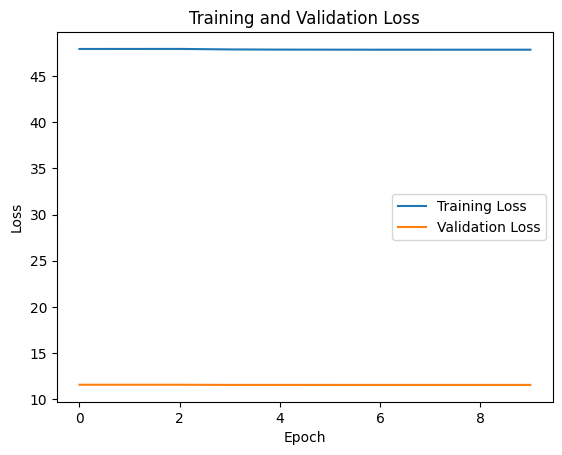

In [ ]:
# Визуализация потерь
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.show()


In [ ]:
import numpy as np
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.initializers import HeNormal
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import tensorflow as tf

# Примерный размер входных данных
input_dim = 128  # Например, окно с 128 отсчетами
encoding_dim = 8  # Размерность bottleneck слоя

# Нормализация данных
scaler = StandardScaler()
x_train_normalized = scaler.fit_transform(train_data_reshaped)
x_val_normalized = scaler.transform(validation_data_reshaped)

# Определение слоев
input_layer = Input(shape=(input_dim,))
encoded = Dense(64, activation='relu', kernel_initializer=HeNormal())(input_layer)
x = Dropout(0.1)(encoded)
x = BatchNormalization()(x)
encoded = Dense(32, activation='relu', kernel_initializer=HeNormal())(x)
x = Dropout(0.1)(encoded)
x = BatchNormalization()(x)
encoded = Dense(16, activation='relu', kernel_initializer=HeNormal())(x)
x = Dropout(0.1)(encoded)
x = BatchNormalization()(x)

bottleneck = Dense(encoding_dim, activation='relu', kernel_initializer=HeNormal())(x)
x = Dropout(0.1)(bottleneck)
x = BatchNormalization()(x)

decoded = Dense(16, activation='relu', kernel_initializer=HeNormal())(x)
x = Dropout(0.1)(decoded)
x = BatchNormalization()(x)
decoded = Dense(32, activation='relu', kernel_initializer=HeNormal())(x)
x = Dropout(0.1)(decoded)
x = BatchNormalization()(x)
decoded = Dense(64, activation='relu', kernel_initializer=HeNormal())(x)
x = Dropout(0.1)(decoded)
x = BatchNormalization()(x)
output_layer = Dense(input_dim, activation='sigmoid', kernel_initializer=HeNormal())(x)

# Создание автоэнкодера
autoencoder = Model(input_layer, output_layer)
autoencoder.compile(optimizer=Adam(learning_rate=0.01), loss='mse')

# Callback для мониторинга градиентов
class GradientMonitor(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        weights = [layer.get_weights() for layer in self.model.layers if len(layer.get_weights()) > 0]
        for i, weight in enumerate(weights):
            print(f"Layer {i} - weights mean: {tf.reduce_mean(weight[0])}, std: {tf.math.reduce_std(weight[0])}")

monitor = GradientMonitor()

# Обучение модели
history = autoencoder.fit(x_train_normalized, x_train_normalized,
                          epochs=50,
                          batch_size=256,
                          shuffle=True,
                          validation_data=(x_val_normalized, x_val_normalized),
                          callbacks=[monitor])

# Визуализация потерь
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.show()


## немного измененное


In [ ]:
# Загрузка train_data
train_data = np.load('/content/drive/MyDrive/train_data128.npy')

# Загрузка val_data
val_data = np.load('/content/drive/MyDrive/val_data128.npy')

print(train_data.shape)
print(val_data.shape)

(1186522, 128)
(1186522, 128)


с разделением на энкодер и декодер


In [ ]:
import numpy as np
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.initializers import HeNormal
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import tensorflow as tf

# Примерный размер входных данных
input_dim = 128  # Например, окно с 128 отсчетами
encoding_dim = 16  # Размерность bottleneck слоя

# Нормализация данных
scaler = StandardScaler()
x_train_normalized = scaler.fit_transform(train_data)
x_val_normalized = scaler.transform(val_data)

# Определение энкодера
input_layer = Input(shape=(input_dim,))
encoded = Dense(64, activation='relu', kernel_initializer=HeNormal())(input_layer)
encoded = Dropout(0.3)(encoded)
encoded = BatchNormalization()(encoded)
encoded = Dense(32, activation='relu', kernel_initializer=HeNormal())(encoded)
encoded = Dropout(0.2)(encoded)
encoded = BatchNormalization()(encoded)
#encoded = Dense(32, activation='relu', kernel_initializer=HeNormal())(encoded)
#encoded = Dropout(0.2)(encoded)
#encoded = BatchNormalization()(encoded)
#encoded = Dense(16, activation='relu', kernel_initializer=HeNormal())(encoded)
#encoded = Dropout(0.1)(encoded)
#encoded = BatchNormalization()(encoded)

bottleneck = Dense(encoding_dim, activation='relu', kernel_initializer=HeNormal())(encoded)
bottleneck = Dropout(0.1)(bottleneck)
bottleneck = BatchNormalization()(bottleneck)

encoder = Model(input_layer, bottleneck, name="encoder")

# Определение декодера
encoded_input = Input(shape=(encoding_dim,))
decoded = Dense(32, activation='relu', kernel_initializer=HeNormal())(encoded_input)
decoded = Dropout(0.2)(decoded)
decoded = BatchNormalization()(decoded)
decoded = Dense(64, activation='relu', kernel_initializer=HeNormal())(decoded)
decoded = Dropout(0.3)(decoded)
decoded = BatchNormalization()(decoded)
#decoded = Dense(64, activation='relu', kernel_initializer=HeNormal())(decoded)
#decoded = Dropout(0.3)(decoded)
#decoded = BatchNormalization()(decoded)
#decoded = Dense(128, activation='relu', kernel_initializer=HeNormal())(decoded)
#decoded = Dropout(0.4)(decoded)
#decoded = BatchNormalization()(decoded)
output_layer = Dense(input_dim, activation='sigmoid', kernel_initializer=HeNormal())(decoded)

decoder = Model(encoded_input, output_layer, name="decoder")

# Создание автоэнкодера
autoencoder_input = Input(shape=(input_dim,))
encoded_repr = encoder(autoencoder_input)
reconstructed_output = decoder(encoded_repr)

autoencoder = Model(autoencoder_input, reconstructed_output, name="autoencoder")
autoencoder.compile(optimizer=Adam(learning_rate=16), loss='mse')



In [ ]:
# Callback для мониторинга градиентов
class GradientMonitor(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        weights = [layer.get_weights() for layer in self.model.layers if len(layer.get_weights()) > 0]
        for i, weight in enumerate(weights):
            print(f"Layer {i} - weights mean: {tf.reduce_mean(weight[0])}, std: {tf.math.reduce_std(weight[0])}")

grad = GradientMonitor()

from tensorflow.keras.callbacks import ReduceLROnPlateau

new_var = 0.001

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5,
                              patience=2, min_lr=new_var)

# Обучение модели
history = autoencoder.fit(x_train_normalized, x_train_normalized,
                          epochs=20,
                          batch_size=128,
                          shuffle=True,
                          validation_data=(x_val_normalized, x_val_normalized),
                          callbacks=[grad, reduce_lr])


Epoch 1/20
9269/9270 [============================>.] - ETA: 0s - loss: 0.7937Layer 0 - weights mean: 8.397931098937988, std: 158.57177734375
Layer 1 - weights mean: 37.46942138671875, std: 780.262451171875
9270/9270 [==============================] - 80s 8ms/step - loss: 0.7937 - val_loss: 0.2455 - lr: 16.0000
Epoch 2/20
9266/9270 [============================>.] - ETA: 0s - loss: 0.8052Layer 0 - weights mean: 5.594205856323242, std: 165.13848876953125
Layer 1 - weights mean: 55.7041130065918, std: 952.7457885742188
9270/9270 [==============================] - 77s 8ms/step - loss: 0.8053 - val_loss: 0.2470 - lr: 16.0000
Epoch 3/20
9267/9270 [============================>.] - ETA: 0s - loss: 0.8310Layer 0 - weights mean: -13.86880111694336, std: 239.22589111328125
Layer 1 - weights mean: 125.27581787109375, std: 1247.1575927734375
9270/9270 [==============================] - 75s 8ms/step - loss: 0.8310 - val_loss: 0.2548 - lr: 16.0000
Epoch 4/20
9265/9270 [============================>

## Циклическая настройка learning_rate

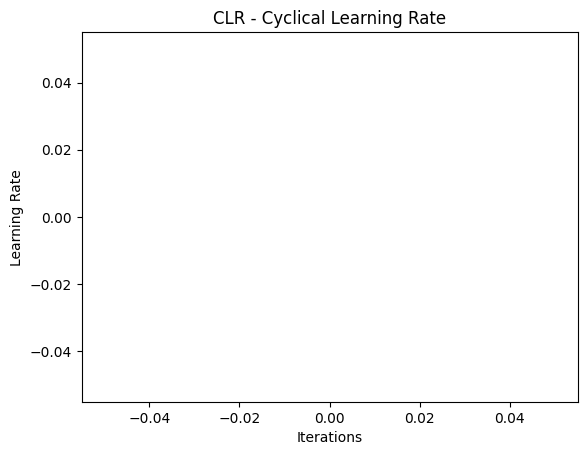

Epoch 1/32
9266/9270 [============================>.] - ETA: 0s - loss: 0.7616Layer 0 - weights mean: -0.7850435972213745, std: 59.95163345336914
Layer 1 - weights mean: 1.2844843864440918, std: 414.4254150390625
9270/9270 [==============================] - 81s 9ms/step - loss: 0.7615 - val_loss: 0.2157
Epoch 2/32
9268/9270 [============================>.] - ETA: 0s - loss: 0.7476Layer 0 - weights mean: -0.6612130403518677, std: 61.26865005493164
Layer 1 - weights mean: 2.018944263458252, std: 419.3699035644531
9270/9270 [==============================] - 80s 9ms/step - loss: 0.7475 - val_loss: 0.2132
Epoch 3/32
9263/9270 [============================>.] - ETA: 0s - loss: 0.7397Layer 0 - weights mean: -0.7202298045158386, std: 60.5769157409668
Layer 1 - weights mean: 0.9106230735778809, std: 419.5503234863281
9270/9270 [==============================] - 80s 9ms/step - loss: 0.7396 - val_loss: 0.2149
Epoch 4/32
9269/9270 [============================>.] - ETA: 0s - loss: 0.7389Layer 0 -

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import Callback
import tensorflow.keras.backend as K

# Callback для мониторинга градиентов
class GradientMonitor(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        weights = [layer.get_weights() for layer in self.model.layers if len(layer.get_weights()) > 0]
        for i, weight in enumerate(weights):
            print(f"Layer {i} - weights mean: {tf.reduce_mean(weight[0])}, std: {tf.math.reduce_std(weight[0])}")

grad = GradientMonitor()

class CyclicLR(Callback):
    def __init__(self, base_lr=0.001, max_lr=0.006, step_size=2000., mode='triangular', gamma=1., scale_fn=None, scale_mode='cycle'):
        super(CyclicLR, self).__init__()

        self.base_lr = base_lr
        self.max_lr = max_lr
        self.step_size = step_size
        self.mode = mode
        self.gamma = gamma
        self.scale_fn = scale_fn
        self.scale_mode = scale_mode
        self.clr_iterations = 0.
        self.trn_iterations = 0.
        self.history = {'lr': [], 'iterations': []}

        if self.scale_fn == None:
            if self.mode == 'triangular':
                self.scale_fn = lambda x: 1.
                self.scale_mode = 'cycle'
            elif self.mode == 'triangular2':
                self.scale_fn = lambda x: 1/(2.**(x-1))
                self.scale_mode = 'cycle'

        self.clr()
        self.plot_lr()

    def clr(self):
        cycle = np.floor(1+self.clr_iterations/(2*self.step_size))
        x = np.abs(self.clr_iterations/self.step_size - 2*cycle + 1)
        if self.scale_mode == 'cycle':
            self.lr = self.base_lr + (self.max_lr-self.base_lr)*np.maximum(0, (1-x))*self.scale_fn(cycle)
        else:
            self.lr = self.base_lr + (self.max_lr-self.base_lr)*np.maximum(0, (1-x))*self.scale_fn(self.clr_iterations)

        self.clr_iterations += 1
        return self.lr

    def on_train_begin(self, logs=None):
        logs = logs or {}

    def on_batch_end(self, batch, logs=None):
        logs = logs or {}
        self.trn_iterations += 1

        self.history['lr'].append(K.get_value(self.model.optimizer.lr))
        self.history['iterations'].append(self.trn_iterations)

        for k, v in logs.items():
            self.history.setdefault(k, []).append(v)

        K.set_value(self.model.optimizer.lr, self.clr())

    def plot_lr(self):
        plt.xlabel("Iterations")
        plt.ylabel("Learning Rate")
        plt.title("CLR - Cyclical Learning Rate")
        plt.plot(self.history['iterations'], self.history['lr'])
        plt.show()


clr = CyclicLR(base_lr=0.03, max_lr=16, step_size=2000, mode='triangular2')
#history = autoencoder.fit(X_train, y_train, epochs=5, batch_size=128, callbacks=[clr])
# Обучение модели
history = autoencoder.fit(x_train_normalized, x_train_normalized,
                          epochs=32,
                          batch_size=128,
                          shuffle=True,
                          validation_data=(x_val_normalized, x_val_normalized),
                          callbacks=[grad, clr])

## построилочки

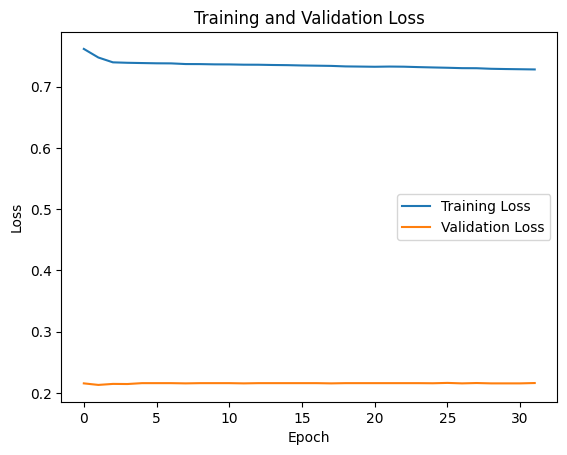

In [ ]:
# Визуализация потерь
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.show()


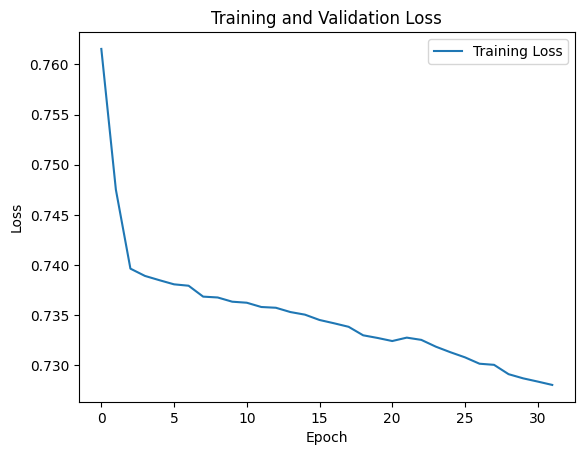

In [ ]:
# Визуализация потерь
plt.plot(history.history['loss'], label='Training Loss')
#plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.show()


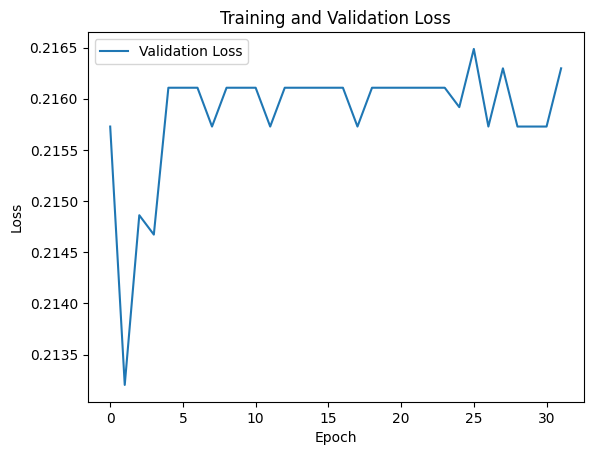

In [ ]:
# Визуализация потерь
#plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.show()


In [ ]:
# Сохранение энкодера для использования
encoder.save('encoder_model_gem0031632.h5')
# Сохранение энкодера на диск
encoder.save('/content/drive/MyDrive/encoder_model_gem0031632.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


## Дальнейшие действия

In [ ]:
from tensorflow.keras.models import load_model

# Загрузка модели с Google Drive (путь к модели должен быть корректным)
model_path = '/content/drive/MyDrive/encoder_model_gem0031632.h5'
loaded_model = load_model(model_path)

# Повторная компиляция модели
loaded_model.compile(optimizer='adam', loss='mse', metrics=['accuracy'])


In [ ]:
from tensorflow.keras.models import load_model

# Загрузка обученного энкодера
trained_encoder = load_model('encoder_model_gem0031632.h5')

# Повторная компиляция модели
trained_encoder.compile(optimizer='adam', loss='mse', metrics=['accuracy'])


In [ ]:
# Использование энкодера для сжатия данных
#features = trained_encoder.predict(train_data)
features = loaded_model.predict(train_data)

print(features.shape)  # (число образцов, encoding_dim)

37079/37079 [==============================] - 53s 1ms/step
(1186522, 16)


остальное

In [ ]:
# Создание модели для выделения признаков
#encoder = Model(input_layer, bottleneck)

# Получение признаков
#features = encoder.predict(train_data_reshaped)

6250/6250 [==============================] - 9s 1ms/step


In [ ]:
#features = encoder.predict(val_data)

37079/37079 [==============================] - 48s 1ms/step


In [ ]:
from sklearn.cluster import KMeans

# Определение числа кластеров (например, 2 для "здоровых" и "эпилептических" данных)
num_clusters = 2
kmeans = KMeans(n_clusters=num_clusters, random_state=0)
kmeans.fit(features)

# Метки кластеров
labels = kmeans.labels_

clusters = kmeans.predict(features)
print(clusters)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


[0 0 0 ... 0 0 0]


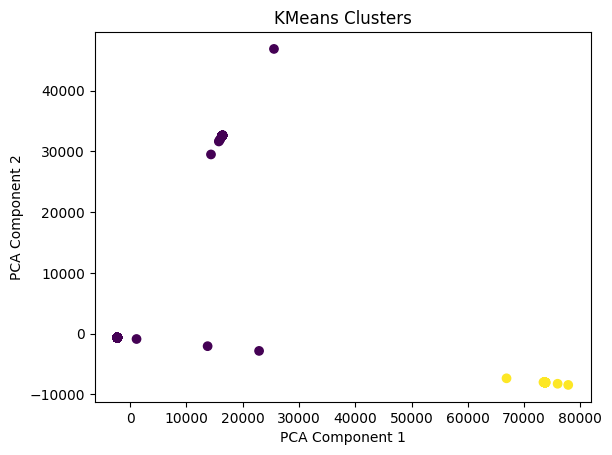

In [ ]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# Снижение размерности для визуализации
pca = PCA(n_components=2)
reduced_features = pca.fit_transform(features)

# Визуализация кластеров
plt.scatter(reduced_features[:, 0], reduced_features[:, 1], c=labels)
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.title('KMeans Clusters')
plt.show()


In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

# Разделение данных на обучающий и тестовый наборы
X_train, X_test, y_train, y_test = train_test_split(features, clusters, test_size=0.2, random_state=42)

# Создание классификатора softmax (логистическая регрессия)
clf = LogisticRegression(max_iter=1000)

# Обучение классификатора на данных кластеризации
clf.fit(X_train, y_train)

# Оценка производительности классификатора
accuracy = clf.score(X_test, y_test)
print(f"Accuracy: {accuracy}")


Accuracy: 1.0


In [ ]:
# Проведение кластеризации на основе z
predicted_clusters = kmeans.predict(features)
print(predicted_clusters)

[0 0 0 ... 0 0 0]


In [ ]:
# Предсказание классов с помощью классификатора
predicted_classes = clf.predict(features)
print(predicted_classes)


[0 0 0 ... 0 0 0]


In [ ]:
from collections import Counter

class_counts = Counter(predicted_classes)
print(class_counts)


Counter({0: 1157723, 1: 28799})


In [ ]:
unique, counts = np.unique(predicted_classes, return_counts=True)
class_counts = dict(zip(unique, counts))

print(class_counts)


{0: 1157723, 1: 28799}


In [ ]:
from statistics import mode

dominant_class = mode(predicted_classes)
print(f"Преобладающий класс: {dominant_class}")


Преобладающий класс: 0


In [ ]:
from sklearn.metrics import classification_report

# Пример истинных и предсказанных меток
y_true = [0, 1, 1, 0, 1]
y_pred = [0, 1, 0, 0, 1]

# Вывод classification report
print(classification_report(y_true, y_pred))


              precision    recall  f1-score   support

           0       0.67      1.00      0.80         2
           1       1.00      0.67      0.80         3

    accuracy                           0.80         5
   macro avg       0.83      0.83      0.80         5
weighted avg       0.87      0.80      0.80         5

